In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [2]:
def get_coefficients(exponent_number, c0, c_fraction):
    coefficients = []
    coefficients.append(c0)
    sum = c0
    for i in range(1, exponent_number - 1):
        c = (1 - sum) * c_fraction
        coefficients.append(c)
        sum += c
    coefficients.append((1 - sum))
    return coefficients

# at x=100 has maximal value of 1
# at x=0 has minimal value of y0
def smearing_func(x, y0):
    return -(1-y0)/10000*x**2+(1-y0)/50*x+y0

# get smearing_steps x smearing_steps matrix of smeared
# first coefficient of the spectral representation
def get_c0_smearing_dependence(smearing_steps, c0):
    c_smeared = []
    y0 = math.sqrt(c0)
    for x in smearing_steps:
        tmp = []
        for y in smearing_steps:
            tmp.append(smearing_func(x, y0) * smearing_func(y, y0))
        c_smeared.append(tmp)
    return c_smeared

# for each c0 smeared matrix element make other coefficients with some ratio
def get_coefficients_smeared(c0_smeared, exponent_number, c_fraction):
    coefficients = []
    for i in range(len(c0_smeared)):
        tmp = []
        for j in range(len(c0_smeared[i])):
            tmp.append(get_coefficients(exponent_number, c0_smeared[i][j], c_fraction))
        coefficients.append(tmp)
    return coefficients

def potential_func(x, alpha, sigma, V0):
    return V0 + alpha / x + sigma * x

# 1
def sigma_dependence(n):
    return 0.0125 * (n + 1)

def alpha_dependence(n):
    return -0.25 * (n + 1)

def V0_dependence(n):
    return 0.5 + 0.5 * n

# 2
# def sigma_dependence(n):
#     return 0.0125

# def alpha_dependence(n):
#     return -0.25

# def V0_dependence(n):
#     return 0.2 + 0.005 * n

# 3
# def sigma_dependence(n):
#     return 0.0125 + 0.03 * n

# def alpha_dependence(n):
#     return -0.25 * (n + 1)

# def V0_dependence(n):
#     return 0.2 - 0.3 * n

def get_wilson_loops_mean(Nt, Ns, exponent_number, coefficients_smeared):
    expotent_enumeration = np.arange(exponent_number, dtype=float)
    sigma_i = sigma_dependence(expotent_enumeration)
    alpha_i = alpha_dependence(expotent_enumeration)
    V0_i = V0_dependence(expotent_enumeration)
    W = np.zeros((Nt, Ns, coefficients_smeared.shape[0], coefficients_smeared.shape[1]))
    for T in range(Nt):
        for R in range(Ns):
            W[T, R] = np.sum(np.exp(-potential_func(R + 1, alpha_i, sigma_i, V0_i) * (T + 1)) * coefficients_smeared, 2)
    return W

def get_relative_error(Nt, Ns, min, k):
    relative_error = np.zeros((Ns, Nt))
    a = math.sqrt(min)
    for i in range(Nt):
        for j in range(Ns):
            # relative_error[i][j] = (a * (i + 1)**k) * (a * (j + 1)**k)
            relative_error[i][j] = 0.0001
    return relative_error

def get_std(Nt, Ns, min, k, W):
    relative_error = get_relative_error(Nt, Ns, min, k)
    std = np.zeros(W.shape)
    # print(std)
    for i in range(Nt):
        for j in range(Ns):
            for m in range(W.shape[2]):
                for n in range(W.shape[3]):
                    std[i][j][m][n] = W[i][j][m][n] * relative_error[i][j]
    return std

def generate_data(W, std_arr):
    return np.random.default_rng().normal(W, std_arr)

def make_data_frame(data, smearing_steps):
    Nt_arr = []
    Ns_arr = []
    smearing1 = []
    smearing2 = []
    W = []
    for j in range(data.shape[0]):
        for k in range(data.shape[1]):
            for m in range(data.shape[2]):
                for n in range(data.shape[3]):
                    Nt_arr.append(j + 1)
                    Ns_arr.append(k + 1)
                    smearing1.append(smearing_steps[m])
                    smearing2.append(smearing_steps[n])
                    W.append(data[j][k][m][n])
    return pd.DataFrame({'smearing_step1': smearing1, 'smearing_step2': smearing2, 'time_size': Nt_arr, 'space_size': Ns_arr, 'wilson_loop': W})

In [3]:
Ns = 20
Nt = 20
N = 50000
exponent_number = 3
c0 = 0.1
c_fraction = 0.8
smearing_steps = [20, 60, 80]
print(get_c0_smearing_dependence(smearing_steps, c0))
coefficients_smeared = np.array(get_coefficients_smeared(get_c0_smearing_dependence(smearing_steps, c0), exponent_number, c_fraction))
print(coefficients_smeared)

[[0.31627775458055896, 0.5008587663332219, 0.5470040192713876], [0.5008587663332219, 0.7931620235053259, 0.8662378377983518], [0.5470040192713876, 0.8662378377983518, 0.9460462924300929]]
[[[0.31627775 0.5469778  0.13674445]
  [0.50085877 0.39931299 0.09982825]
  [0.54700402 0.36239678 0.0905992 ]]

 [[0.50085877 0.39931299 0.09982825]
  [0.79316202 0.16547038 0.0413676 ]
  [0.86623784 0.10700973 0.02675243]]

 [[0.54700402 0.36239678 0.0905992 ]
  [0.86623784 0.10700973 0.02675243]
  [0.94604629 0.04316297 0.01079074]]]


In [4]:
Ns = 20
Nt = 20
N = 50000
exponent_number = 3
c0 = 0.1
c_fraction = 0.8
smearing_steps = [20, 40, 60, 70, 80]
coefficients_smeared = np.array(get_coefficients_smeared(get_c0_smearing_dependence(smearing_steps, c0), exponent_number, c_fraction))
W = get_wilson_loops_mean(Nt, Ns, exponent_number, coefficients_smeared)
std_arr = get_std(Nt, Ns, 0.001, 1.01, W)
for i in range(N):
    data = generate_data(W, std_arr)
    df = make_data_frame(data, smearing_steps)
    df = df[df['smearing_step2'] >= df['smearing_step1']]
    df.to_csv(f'/home/ilya/soft/lattice/observables/data/synthetic/wilson_gevp/conf_{(i+1):05}', index=False)

[0.6416225429426708, 0.6152355581907011, 0.6013003448347551, 0.593818485267876, 0.5897453525474081, 0.5875068698398165, 0.5862694269591436, 0.5855829902424795, 0.5852014492289186, 0.5849891380631905, 0.5848709208542316, 0.5848050727365308, 0.5847683873960524, 0.5847479469653359, 0.5847365572079642, 0.5847302104209641, 0.584726673692257, 0.5847247028392317, 0.5847236045687031]


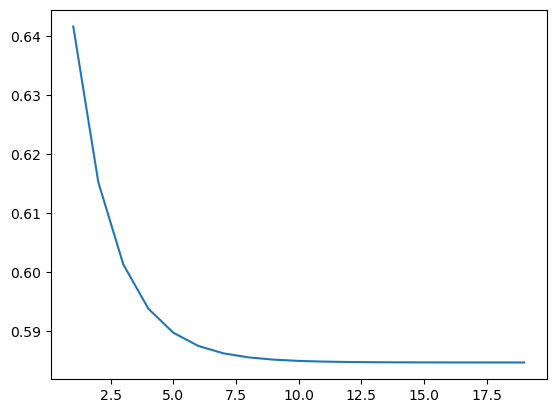

In [11]:
y = []
x = []
for i in range(Nt-1):
    x.append(i + 1)
    y.append(math.log(W[i][8][1][1]/W[i+1][8][1][1]))
print(y)
plt.plot(x, y)

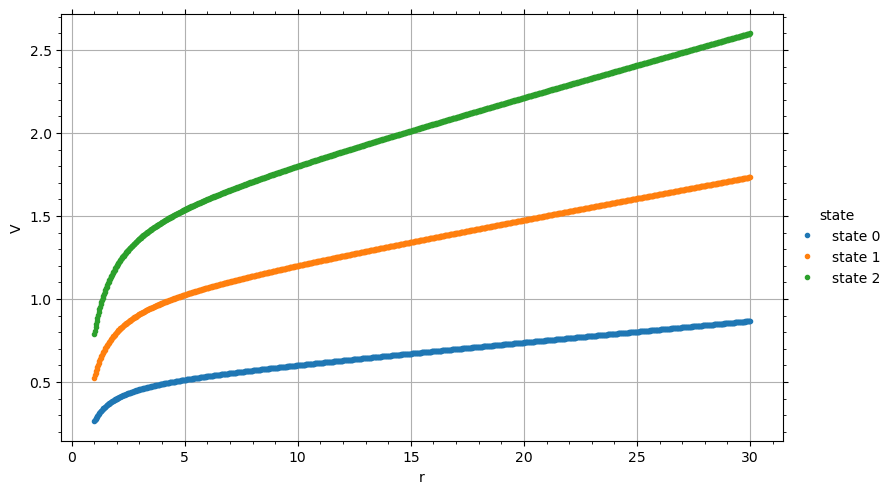

In [12]:
x = np.linspace(1, 30, 1000)
df = []
for i in range(3):
    y = potential_func(x, alpha_dependence(i), sigma_dependence(i), V0_dependence(i))
    df.append(pd.DataFrame({'r': x, 'V': y, 'state': f'state {i}'}))
df = pd.concat(df)
fg = seaborn.FacetGrid(data=df, hue='state', height=5, aspect=1.61, legend_out=True)
fg.map(plt.errorbar, 'r', 'V', mfc=None, fmt='o', ms=3, capsize=5, lw=0.5, ls=None).add_legend()
fg.ax.set_xlabel('r')
fg.ax.set_ylabel('V')
fg.ax.spines['right'].set_visible(True)
fg.ax.spines['top'].set_visible(True)
fg.ax.minorticks_on()
fg.ax.tick_params(which='both', bottom=True,
                  top=True, left=True, right=True)
plt.grid(dash_capstyle='round')
plt.show()